In [133]:
import pandas as pd
import numpy as np
import random

import quantlib
import quantlib.indicators_cal as indicators_cal
import quantlib.diagnostics_utils as diagnostics_utils

import warnings
warnings.filterwarnings('ignore')

In [308]:
def get_instruments_from_df(df):
    instruments = []
    for col in df.columns:
        inst = col.split(" ")[0]
        if "USD" in inst and inst not in instruments:
            instruments.append(inst)
    return instruments

origin_df = pd.read_excel("../crypto_historical_4h.xlsx", engine="openpyxl", index_col='open_time')
origin_df.head()

In [ ]:
periods = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 100]
look_ahead = periods[2]
IGNORES = 1 # We do not want to count the closest momentum for possible reversion

instruments = get_instruments_from_df(origin_df)
remove_instruments = []

df = origin_df.copy()
for inst in instruments:
    for p in periods:
        df["{} {} ret".format(inst, p)] = df["{} close".format(inst)].shift(IGNORES) / df["{} close".format(inst)].shift(p+IGNORES) - 1
        df["{} {} fwd ret".format(inst, p)] = df["{} close".format(inst)].shift(-p) / df["{} close".format(inst)] - 1

for inst in instruments:
    if df[f"{inst} {periods[0]} fwd ret"].iloc[0] == 0:
        remove_instruments.append(inst)

df_cols = [col for col in df.columns if col.split(" ")[0] not in remove_instruments]
df = df[df_cols]

In [ ]:
target_instruments = [x for x in instruments if x not in remove_instruments]

def set_rank_df(periods, index, rank_df, target_df, instruments):
    for inst in instruments:
        for p in periods:
            rank_df.loc[index, f"{inst} {p} ret"] = target_df.loc[index, f"{inst} {p} ret"]
            rank_df.loc[index, f"{inst} {p} fwd ret"] = target_df.loc[index, f"{inst} {p} fwd ret"]
    return rank_df

def get_momentum_rank(df, rebalance_period=10):
    instruments = get_instruments_from_df(df)
    target_df = df.copy().reset_index()
    rank_df = pd.DataFrame()
    for i in target_df.index:
        if i % rebalance_period == 1 and i != 1:
            rank_df = set_rank_df(periods, i, rank_df, target_df, instruments)

    rank_df = rank_df.dropna(axis=0).reset_index(drop=True)
    return rank_df

rank_df = get_momentum_rank(df, look_ahead)

In [ ]:
rank_df

,BTCUSDT 10 ret,BTCUSDT 10 fwd ret,BTCUSDT 15 ret,BTCUSDT 15 fwd ret,BTCUSDT 20 ret,BTCUSDT 20 fwd ret,BTCUSDT 25 ret,BTCUSDT 25 fwd ret,BTCUSDT 30 ret,BTCUSDT 30 fwd ret,...,LPTUSDT 60 ret,LPTUSDT 60 fwd ret,LPTUSDT 65 ret,LPTUSDT 65 fwd ret,LPTUSDT 70 ret,LPTUSDT 70 fwd ret,LPTUSDT 75 ret,LPTUSDT 75 fwd ret,LPTUSDT 100 ret,LPTUSDT 100 fwd ret
0,-0.079113,0.050780,-0.043207,0.058481,-0.054907,0.055627,-0.044947,0.073531,-0.050052,0.031428,...,0.066122,-0.345139,-0.089718,-0.378892,-0.081380,-0.387187,-0.045333,-0.430158,-0.081586,-0.506656
1,-0.000972,-0.022924,0.056911,-0.015518,0.052322,-0.098283,0.064979,-0.148017,-0.030930,-0.152234,...,0.026150,-0.297783,-0.026711,-0.296743,0.117152,-0.278450,-0.055967,-0.308622,-0.228398,-0.328106
2,-0.056683,-0.059832,-0.062524,-0.059260,-0.063710,-0.010971,-0.074531,-0.029111,-0.064620,-0.048009,...,-0.063983,-0.241744,-0.027189,-0.227068,-0.039445,-0.210255,-0.107729,-0.121546,-0.182887,-0.207538
3,0.061207,-0.037448,0.033370,-0.075701,-0.050769,-0.064783,-0.097081,-0.052550,-0.104574,-0.045291,...,-0.299808,-0.180495,-0.201929,-0.156869,-0.267263,-0.149416,-0.069152,-0.191039,-0.157976,0.035785
4,-0.049196,0.020842,-0.042850,0.013091,-0.057315,-0.024201,-0.012326,0.004630,0.000384,0.011595,...,-0.286089,-0.080734,-0.315455,-0.066268,-0.354161,0.028016,-0.309800,0.087307,-0.256029,0.190480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.000706,-0.007721,0.018975,-0.005382,0.016060,0.077604,0.091799,0.077119,0.121717,0.066034,...,0.327898,0.239743,0.336438,0.182784,0.367680,0.202092,0.330243,0.168785,0.337328,0.357039
126,0.084367,-0.010736,0.082583,0.000419,0.071014,0.004868,0.071080,-0.014417,0.071770,0.003576,...,0.296154,0.075038,0.301158,0.098315,0.305935,0.160796,0.396510,0.162328,0.339260,0.404900
127,0.009663,-0.001286,0.006936,0.002307,0.012924,0.004084,0.093828,0.000039,0.098382,0.038305,...,0.160931,0.220903,0.281087,0.237116,0.310358,0.243052,0.331914,0.270122,0.516527,0.229444
128,0.004647,0.034082,0.020893,0.003012,0.006282,-0.010909,0.012216,-0.001644,0.016006,0.032161,...,0.260538,0.190655,0.245246,0.344192,0.231917,0.331733,0.270234,0.296820,0.537652,0.121350


In [ ]:
look_back = periods[6]
k=10

portfolio_df = pd.DataFrame(index=rank_df.index)
target_ret_cols = [f"{inst} {look_back} ret" for inst in target_instruments]
target_fwd_ret_cols = [f"{inst} {look_ahead} fwd ret" for inst in target_instruments]


for i in rank_df.index:
    rank = pd.qcut(rank_df.loc[i, target_ret_cols], k, labels=False)
    for col in target_ret_cols:
        portfolio_df.loc[i, col] = int(rank[col])
    for col in target_fwd_ret_cols:
        portfolio_df.loc[i, col] = rank_df.loc[i, col]


def lookup_ret(index, portfolio_df, rank_portfolio):
    fwd_ret_cols = []
    ret_cols = []
    for inst in rank_portfolio:
        for col in target_fwd_ret_cols:
            if inst in col: fwd_ret_cols.append(col)
        for col in target_ret_cols:
            if inst in col: ret_cols.append(col)
    inst_fwd_ret = rank_df.loc[index, fwd_ret_cols].mean()
    inst_ret = rank_df.loc[index, ret_cols].mean()
    return inst_fwd_ret, inst_ret
        

rank_cols = [i for i in range(k)]
result_df = pd.DataFrame(index=portfolio_df.index, columns=rank_cols)
for i in portfolio_df.index:
    result_df.loc[i, rank_cols] = [[] for _ in range(k)]
    for col in target_ret_cols:
        inst = col.split(" ")[0]
        rank = portfolio_df.loc[i, col]
        result_df.loc[i, rank].append(inst)

for i in result_df.index:
    for rank in result_df[rank_cols]:
        rank_portfolio = result_df.loc[i, rank]
        inst_fwd_ret, inst_ret = lookup_ret(i, portfolio_df, rank_portfolio)
        result_df.loc[i, f"rank {rank} fwd ret"] = inst_fwd_ret
        result_df.loc[i, f"rank {rank} ret"] = inst_ret


fwd_ret = result_df[[f"rank {rank} fwd ret" for rank in range(k)]].mean().reset_index(drop=True)
ret = result_df[[f"rank {rank} ret" for rank in range(k)]].mean().reset_index(drop=True)
compare_df = pd.concat({f"{look_back} Return": ret, f"{look_ahead} Forward Return": fwd_ret},
                    axis=1)
compare_df = compare_df.apply(lambda x: x*100)

compare_df



,40 Return,20 Forward Return
0,-12.660434,-0.946987
1,-7.935351,-0.588638
2,-5.978971,-0.640327
3,-4.558117,-0.583034
4,-3.213361,-0.708446
5,-1.968868,-0.559642
6,-0.398024,-0.444332
7,1.648680,-0.774458
8,4.827609,-0.709400
9,17.720817,-0.733576


In [ ]:
"""
k_list = np.arange(10, 21)
look_back_list = periods

max_sharpe, max_k, max_look_back = 0, 0, 0
for k in k_list:
    for look_back in look_back_list:
        sharpe = main(look_back, k)
        print (sharpe)
        if sharpe > max_sharpe:
            max_sharpe = sharpe
            max_k, max_look_back = k, look_back

print (max_sharpe, max_k, max_look_back)
"""

'\nk_list = np.arange(10, 21)\nlook_back_list = periods\n\nmax_sharpe, max_k, max_look_back = 0, 0, 0\nfor k in k_list:\n    for look_back in look_back_list:\n        sharpe = main(look_back, k)\n        print (sharpe)\n        if sharpe > max_sharpe:\n            max_sharpe = sharpe\n            max_k, max_look_back = k, look_back\n\nprint (max_sharpe, max_k, max_look_back)\n'

Sharpe ratio: 0.5493908693744474
Max drawdown: -36.0833372721681%


<Axes: >

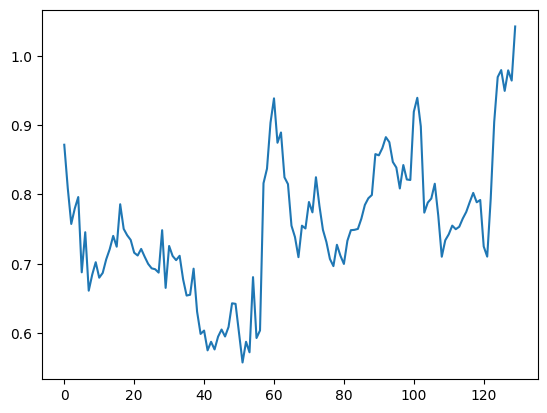

In [ ]:
result_df["portfolio ret"] = result_df[f"rank {k-1} fwd ret"] - result_df["rank 0 fwd ret"]
sharpe = result_df["portfolio ret"].mean() / result_df["portfolio ret"].std() * np.sqrt(253)

result_df["portfolio ret"] = (1+result_df["portfolio ret"]).cumprod()
result_df["drawdown"] = result_df["portfolio ret"] / result_df["portfolio ret"].cummax() - 1
max_drawdown = result_df["drawdown"].min()*100
print (f"Sharpe ratio: {sharpe}")
print (f"Max drawdown: {max_drawdown}%")
result_df["portfolio ret"].plot()

In [ ]:
# IGNORES = 5
# look back, look ahead = 50, 50
# k=12


"""
4h: lookback=40, lookahead=20, k=20, IGNORE=1
sharpe: 5.64
"""